# <a name="0">State Farm Distracted Driver Detection</a>

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black">Table of Contents</div>   
    
- Introduction
    
- Import Modules

- Load Dataset
    
- Exploratory Data Analysis
        
- Split the Dataset

- Create Generators for the Dataset

- Plot Samples of Our Dataset

- Model Structure

- Fit the model

- Evaluate the model


    
 


## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black">Introduction</div>   

# Objective
Given a dataset of 2D dashboard camera images, an algorithm needs to be developed to classify each driver's behaviour and determine if they are driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat etc..? This can then be used to automatically detect drivers engaging in distracted behaviours from dashboard cameras.

# Dataset
The provided data set has driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). This dataset is obtained from  [Kaggle](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview).


The 10 classes to predict are:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## File descriptions

- `imgs` - Folder of all (train/test) images
- `sample_submission.csv` - a sample submission file in the correct format
- `driver_imgs_list.csv` - a list of training images, their subject (driver) id, and class id
In our case, we are going to use only the images from the `train` folder present inside the `imgs` folder.

## The Model
In our project, we have trained the dataset using:

- **Yolo v8 Model**

## Spliting Approach 

We have used method for creating directories for training set, validation set and test set, with using simpler method by taking the benefit of `splitfolders` module

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black">Import Modules</div>   

### Importing all the libraries that we will be requiring during our project

In [1]:
# import system libs
import os
import csv
import time
import shutil
import pathlib
import datetime
import itertools
from glob import glob
from tqdm import tqdm
from getpass import getpass
from shutil import copyfile
from random import shuffle, seed


# import data handling tools
import splitfolders
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from IPython.display import display, Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from ultralytics import YOLO


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('Modules Loaded')

Modules Loaded


## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Load Dataset </div>  

## Let us load our data and explore it a bit

As per the dataset below, we have `7000` images in the `training dataset`. We are gonna split it in three sets (train, val and test), respectively We will ignore `testing dataset` as we don't have any labels for them.

In [2]:
data = {}

with open(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Driver Images List.csv") as file:
    read_file = csv.reader(file)
    read_file = list(read_file)
    
    for row in read_file[1:]:
        key = row[1]
        if key in data:
            data[key].append(row[2])
        else:
            data[key] = [row[2]]

In [3]:
classes_list = list(data.keys())
classes_list

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

#### We have 10 classes in total (`c0`, `c1`, `c2`, `c3`, `c4`, `c5`, `c6`, `c7`, `c8`, `c9`)


### In this part we are going to extract an image of each class we have.

In [4]:
# Generate data paths with labels
data_dir = "D:\\Personal\\5. Courses\\Depi\\Technical\\Dataset\\Images"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df.head()

filepaths labels
0  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c0
1  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c0
2  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c0
3  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c0
4  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c0

In [6]:
df.tail(10)

filepaths labels
6990  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6991  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6992  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6993  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6994  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6995  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6996  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6997  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6998  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9
6999  D:\Personal\5. Courses\Depi\Technical\Dataset\...     c9

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Exploratory Data Analysis </div>   

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  7000 non-null   object
 1   labels     7000 non-null   object
dtypes: object(2)
memory usage: 109.5+ KB


In [8]:
print("Shape of The Dataset:", df.shape)

Shape of The Dataset: (7000, 2)


In [9]:
print("Number of Unique Values:")
print(df.nunique())

Number of Unique Values:
filepaths    7000
labels         10
dtype: int64


In [10]:
print("Number of Null Values:")
print(df.isnull().sum())

Number of Null Values:
filepaths    0
labels       0
dtype: int64


## Now, we will see the distrubution of data in every class.

In [11]:
def summary_with_graph(dataframe, col_name):
    
    #Subplots
    fig = make_subplots(rows = 1, cols = 2,
                        subplot_titles = ('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])
    #Barchart
    fig.add_trace(go.Bar(y = dataframe[col_name].value_counts().values.tolist(),
                         x = [str(i) for i in dataframe[col_name].value_counts().index],
                         text = dataframe[col_name].value_counts().values.tolist(),
                         textfont = dict(size = 15),
                         name = col_name,
                         textposition = 'auto',
                         showlegend = False,
                         marker = dict(color = colors,
                                     line = dict(color = '#DBE6EC',
                                               width = 1))),
                  row = 1, col = 1)

    #Piechart
    fig.add_trace(go.Pie(labels = dataframe[col_name].value_counts().keys(),
                         values = dataframe[col_name].value_counts().values,
                         textfont = dict(size = 20),
                         textposition = 'auto',
                         showlegend = False,
                         name = col_name,
                         marker = dict(colors = colors)),
                  row = 1, col = 2)

    fig.update_layout(title = {'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template = 'plotly_white')

    iplot(fig)

In [12]:
colors = ['#0FC2C0', '#0CABA8', '#008F8C', '#015958', '#023535',
              '#0FC2C0', '#0CABA8', '#008F8C', '#015958', '#023535']

In [13]:
summary_with_graph(df, 'labels')

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Split Dataset into Train & Validation & Test</div>   


### We will split the data in three parts.
* Training dataset (80%)
* Validation dataset (10%)
* Testing dataset (10%)

In [14]:
splitfolders.ratio(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images", output = 'Output', seed = 7, ratio = (0.8, 0.1, 0.1))

Copying files: 7000 files [00:09, 731.54 files/s] 


In [15]:
parent_dir = r"D:\Personal\5. Courses\Depi\Technical\Dataset"
train_dir = r"D:\Personal\5. Courses\Depi\Technical\Dataset\Train"
val_dir = r"D:\Personal\5. Courses\Depi\Technical\Dataset\Val"
test_dir = r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test"

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Plot Samples of Our Data </div>  


## First, we start by Visualizing the Variable of Interest.

## Let's view more Images in a Grid Format.

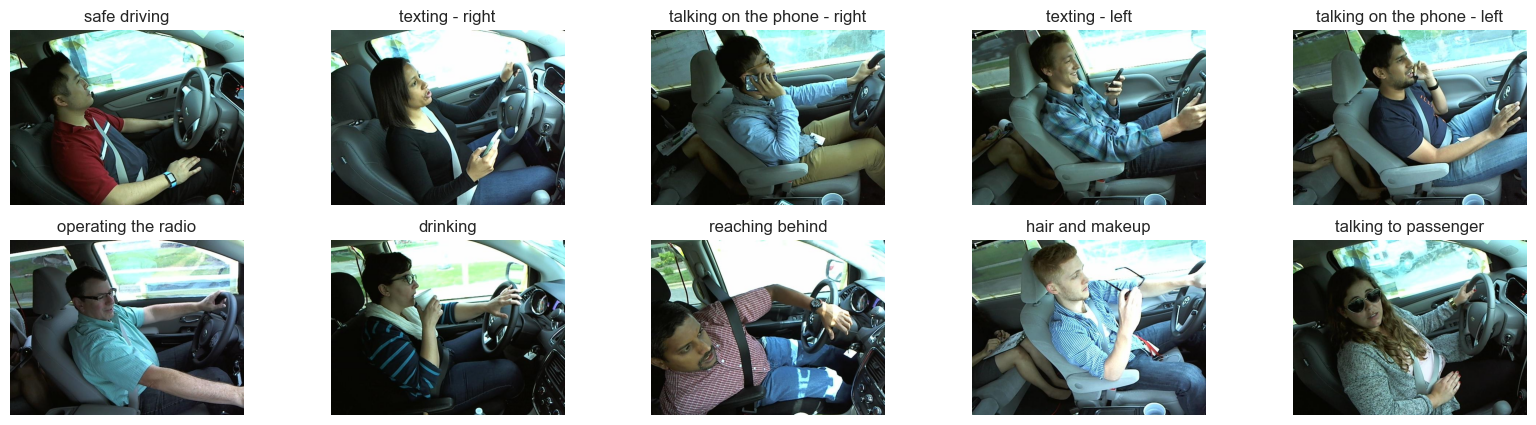

In [16]:
state = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger', 'UNKNOWN']

def Display(path, Class=None):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if Class == None:
        plt.figure()
        plt.title(state[10])
        plt.imshow(img)
        plt.axis("off")
        # print(img.shape)
    else:
        plt.subplot(2, 5, Class+1)
        plt.title(state[Class])
        plt.imshow(img)
        plt.axis("off")

plt.figure(figsize=(20, 5))
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c0\img_2151.jpg", 0)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c1\img_872.jpg", 1)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c2\img_7061.jpg", 2)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c3\img_2770.jpg", 3)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c4\img_568.jpg", 4)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c5\img_4092.jpg", 5)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c6\img_8389.jpg", 6)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c7\img_3489.jpg", 7)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c8\img_10650.jpg", 8)
Display(r"D:\Personal\5. Courses\Depi\Technical\Dataset\Images\c9\img_8076.jpg", 9)

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Image Data Generator & Flow from Directory</div>   

## Creating Function using Tensorflow's `ImageDataGenerator` Module for our image preprocessing

`imagedatageneration` function will be created that will return three generated batches of tensor image-data namely:
- train_generator (generated from our train folder)
- val_generator (generated from our val folder)
- test_generator (generated from our test folder)

In [17]:
def imagedatageneration(train_dir, val_dir, test_dir, target_size = (256, 256), batch_size = 64):
    
    
    ## It can be seen that the augmentation is applied only on the training set.
    ## We have skipped it for val because it is not recommended. But we can try and experiment with it later
    
    train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                       rotation_range = 30,
                                       width_shift_range = 0.1,
                                       height_shift_range = 0.1,
                                       zoom_range = 0.1,
                                       shear_range = 0.1,
                                       fill_mode = "nearest"
                                      )
    train_generator = train_datagen.flow_from_directory(
                                                            train_dir,
                                                            target_size = target_size,
                                                            class_mode = 'categorical',
                                                            shuffle = True,
                                                            batch_size = batch_size
                                                        )
    
    
    val_datagen = ImageDataGenerator(rescale = 1.0 / 255)
    
    val_generator = val_datagen.flow_from_directory(
                                                        val_dir,
                                                        target_size = target_size,
                                                        class_mode = 'categorical',
                                                        shuffle = True,
                                                        batch_size = batch_size
                                                    )
    
    test_datagen = ImageDataGenerator(rescale = 1.0/255)
    test_generator = test_datagen.flow_from_directory(
                                                        test_dir,
                                                        target_size = target_size,
                                                        class_mode = 'categorical',
                                                        shuffle = False,
                                                        batch_size = 1
                                                      )
    
    return train_generator, val_generator, test_generator

In [18]:
train_generator, val_generator, test_generator = imagedatageneration(train_dir, val_dir, test_dir)

Found 5600 images belonging to 10 classes.
Found 700 images belonging to 10 classes.
Found 700 images belonging to 10 classes.


## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Deep Learning Model </div> 

### Creating the Object of Out Yolo Model

In [19]:
model = YOLO('yolov8n-cls.pt')

In [20]:
results = model.train(data = parent_dir, epochs = 15)

Ultralytics 8.3.4  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6920HQ 2.90GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=D:\Personal\5. Courses\Depi\Technical\Dataset, epochs=15, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mostafa-gamal2288822 (mostafa-gamal2288822-microsoft-office). Use `wandb login --relogin` to force relogin


train: Scanning D:\Personal\5. Courses\Depi\Technical\Dataset\train... 5600 images, 0 corrupt: 100%|██████████| 5600/56


train: New cache created: D:\Personal\5. Courses\Depi\Technical\Dataset\train.cache


val: Scanning D:\Personal\5. Courses\Depi\Technical\Dataset\val... 700 images, 0 corrupt: 100%|██████████| 700/700 [00:


val: New cache created: D:\Personal\5. Courses\Depi\Technical\Dataset\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\train5
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:12<00:00,  1.70it/s]

                   all       0.86       0.99



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.11it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.10it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:11<00:00,  1.98it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.08it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:11<00:00,  1.98it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:12<00:00,  1.83it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.01it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      10/15         0G     0.1394         16        224: 100%|██████████| 350/350 [02:52<00:00,  2.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:11<00:00,  2.00it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      11/15         0G     0.1164         16        224: 100%|██████████| 350/350 [02:53<00:00,  2.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.04it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


      12/15         0G     0.1219         16        224: 100%|██████████| 350/350 [02:54<00:00,  2.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:11<00:00,  2.00it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


      13/15         0G     0.1083         16        224: 100%|██████████| 350/350 [02:58<00:00,  1.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.02it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      14/15         0G     0.1064         16        224: 100%|██████████| 350/350 [02:54<00:00,  2.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.10it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      15/15         0G    0.09433         16        224: 100%|██████████| 350/350 [02:55<00:00,  2.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.02it/s]

                   all      0.996          1



15 epochs completed in 0.784 hours.
Optimizer stripped from runs\classify\train5\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train5\weights\best.pt, 3.0MB

Validating runs\classify\train5\weights\best.pt...
Ultralytics 8.3.4  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6920HQ 2.90GHz)
YOLOv8n-cls summary (fused): 73 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: D:\Personal\5. Courses\Depi\Technical\Dataset\train... found 5600 images in 10 classes  
val: D:\Personal\5. Courses\Depi\Technical\Dataset\val... found 700 images in 10 classes  
test: D:\Personal\5. Courses\Depi\Technical\Dataset\test... found 700 images in 10 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 22/22 [00:10<00:00,  2.11it/s]


                   all      0.996          1
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train5
Results saved to runs\classify\train5


In [22]:
model.val()

Ultralytics 8.3.4  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i7-6920HQ 2.90GHz)
YOLOv8n-cls summary (fused): 73 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: D:\Personal\5. Courses\Depi\Technical\Dataset\train... found 5600 images in 10 classes  
val: D:\Personal\5. Courses\Depi\Technical\Dataset\val... found 700 images in 10 classes  
test: D:\Personal\5. Courses\Depi\Technical\Dataset\test... found 700 images in 10 classes  


val: Scanning D:\Personal\5. Courses\Depi\Technical\Dataset\val... 700 images, 0 corrupt: 100%|██████████| 700/700 [00:
               classes   top1_acc   top5_acc: 100%|██████████| 44/44 [00:10<00:00,  4.29it/s]


                   all      0.996          1
Speed: 0.0ms preprocess, 4.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train52


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000200AFD7D8D0>
curves: []
curves_results: []
fitness: 0.9978571534156799
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9957143068313599, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9978571534156799}
save_dir: WindowsPath('runs/classify/train52')
speed: {'preprocess': 0.001423018319266183, 'inference': 4.153100422450475, 'loss': 0.0, 'postprocess': 0.0014243807111467633}
task: 'classify'
top1: 0.9957143068313599
top5: 1.0

In [23]:
df = pd.read_csv(r"D:\Personal\5. Courses\Depi\Technical\Runs\Classify\Train\results.csv")
df.head()

epoch               train/loss    metrics/accuracy_top1  \
0                        1                  1.87570                  0.86000   
1                        2                  0.62142                  0.96429   
2                        3                  0.37917                  0.96143   
3                        4                  0.30714                  0.97286   
4                        5                  0.24087                  0.97857   

     metrics/accuracy_top5                 val/loss                   lr/pg0  \
0                     0.99                   1.7541                 0.000237   
1                     1.00                   1.5523                 0.000444   
2                     1.00                   1.5258                 0.000619   
3                     1.00                   1.5018                 0.000573   
4                     1.00                   1.4919                 0.000526   

                    lr/pg1                   lr/pg2  
0                 0.000237                 0.000237  
1                 0.000444                 0.000444  
2                 0.000619                 0.000619  
3                 0.000573                 0.000573  
4                 0.000526                 0.000526

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Plot Acc and Loss Curves </div> 

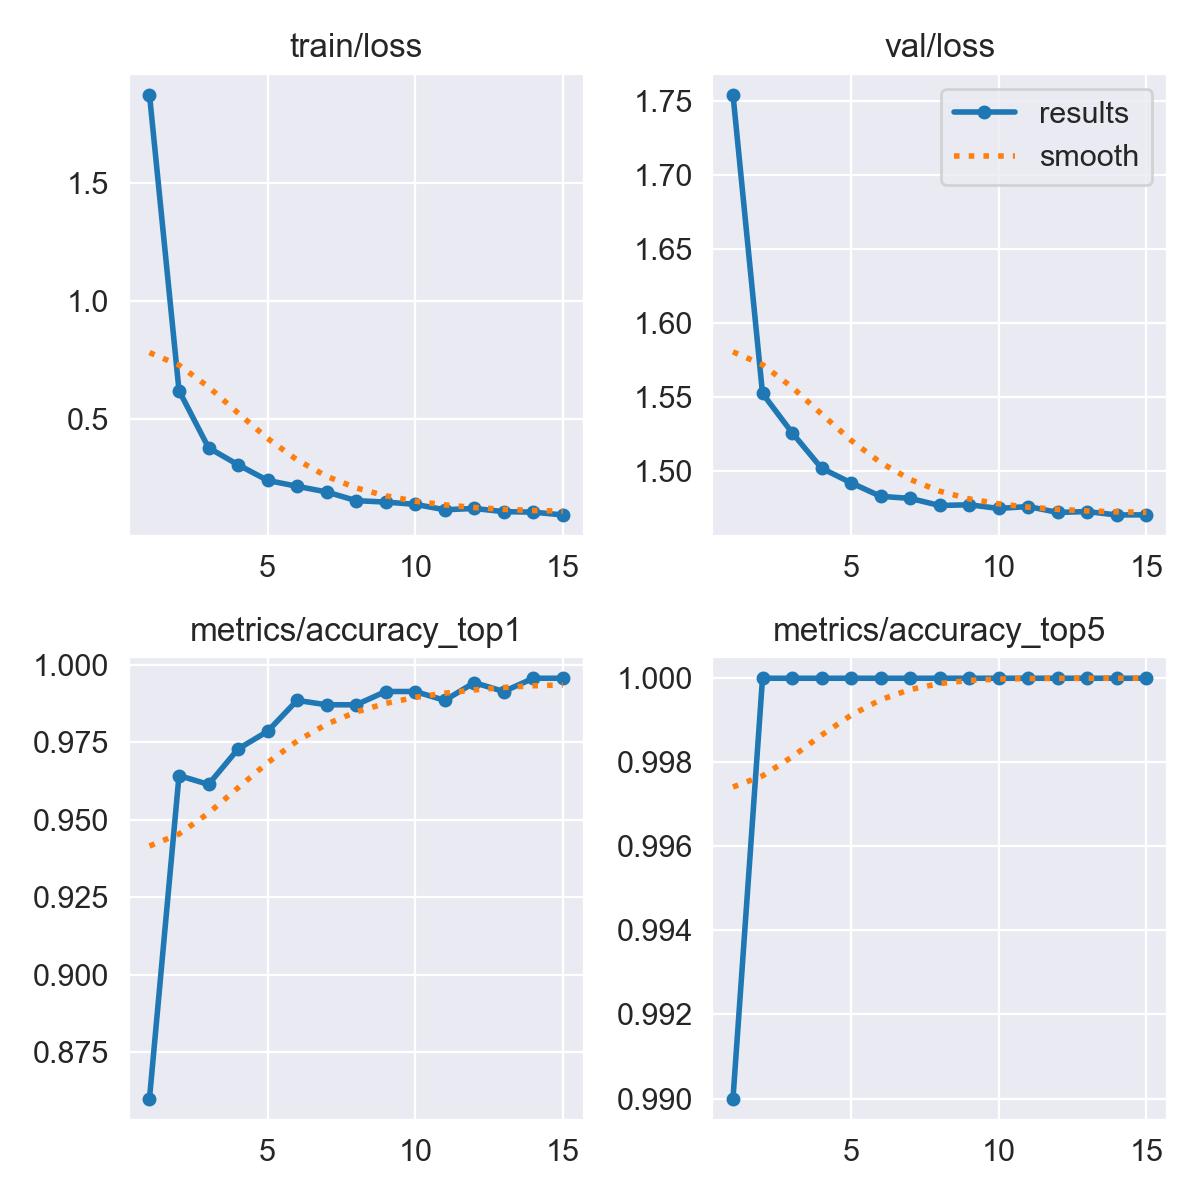

In [24]:
Image(r"D:\Personal\5. Courses\Depi\Technical\Runs\Classify\Train\results.png")

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Plot Confussion Matrix </div> 

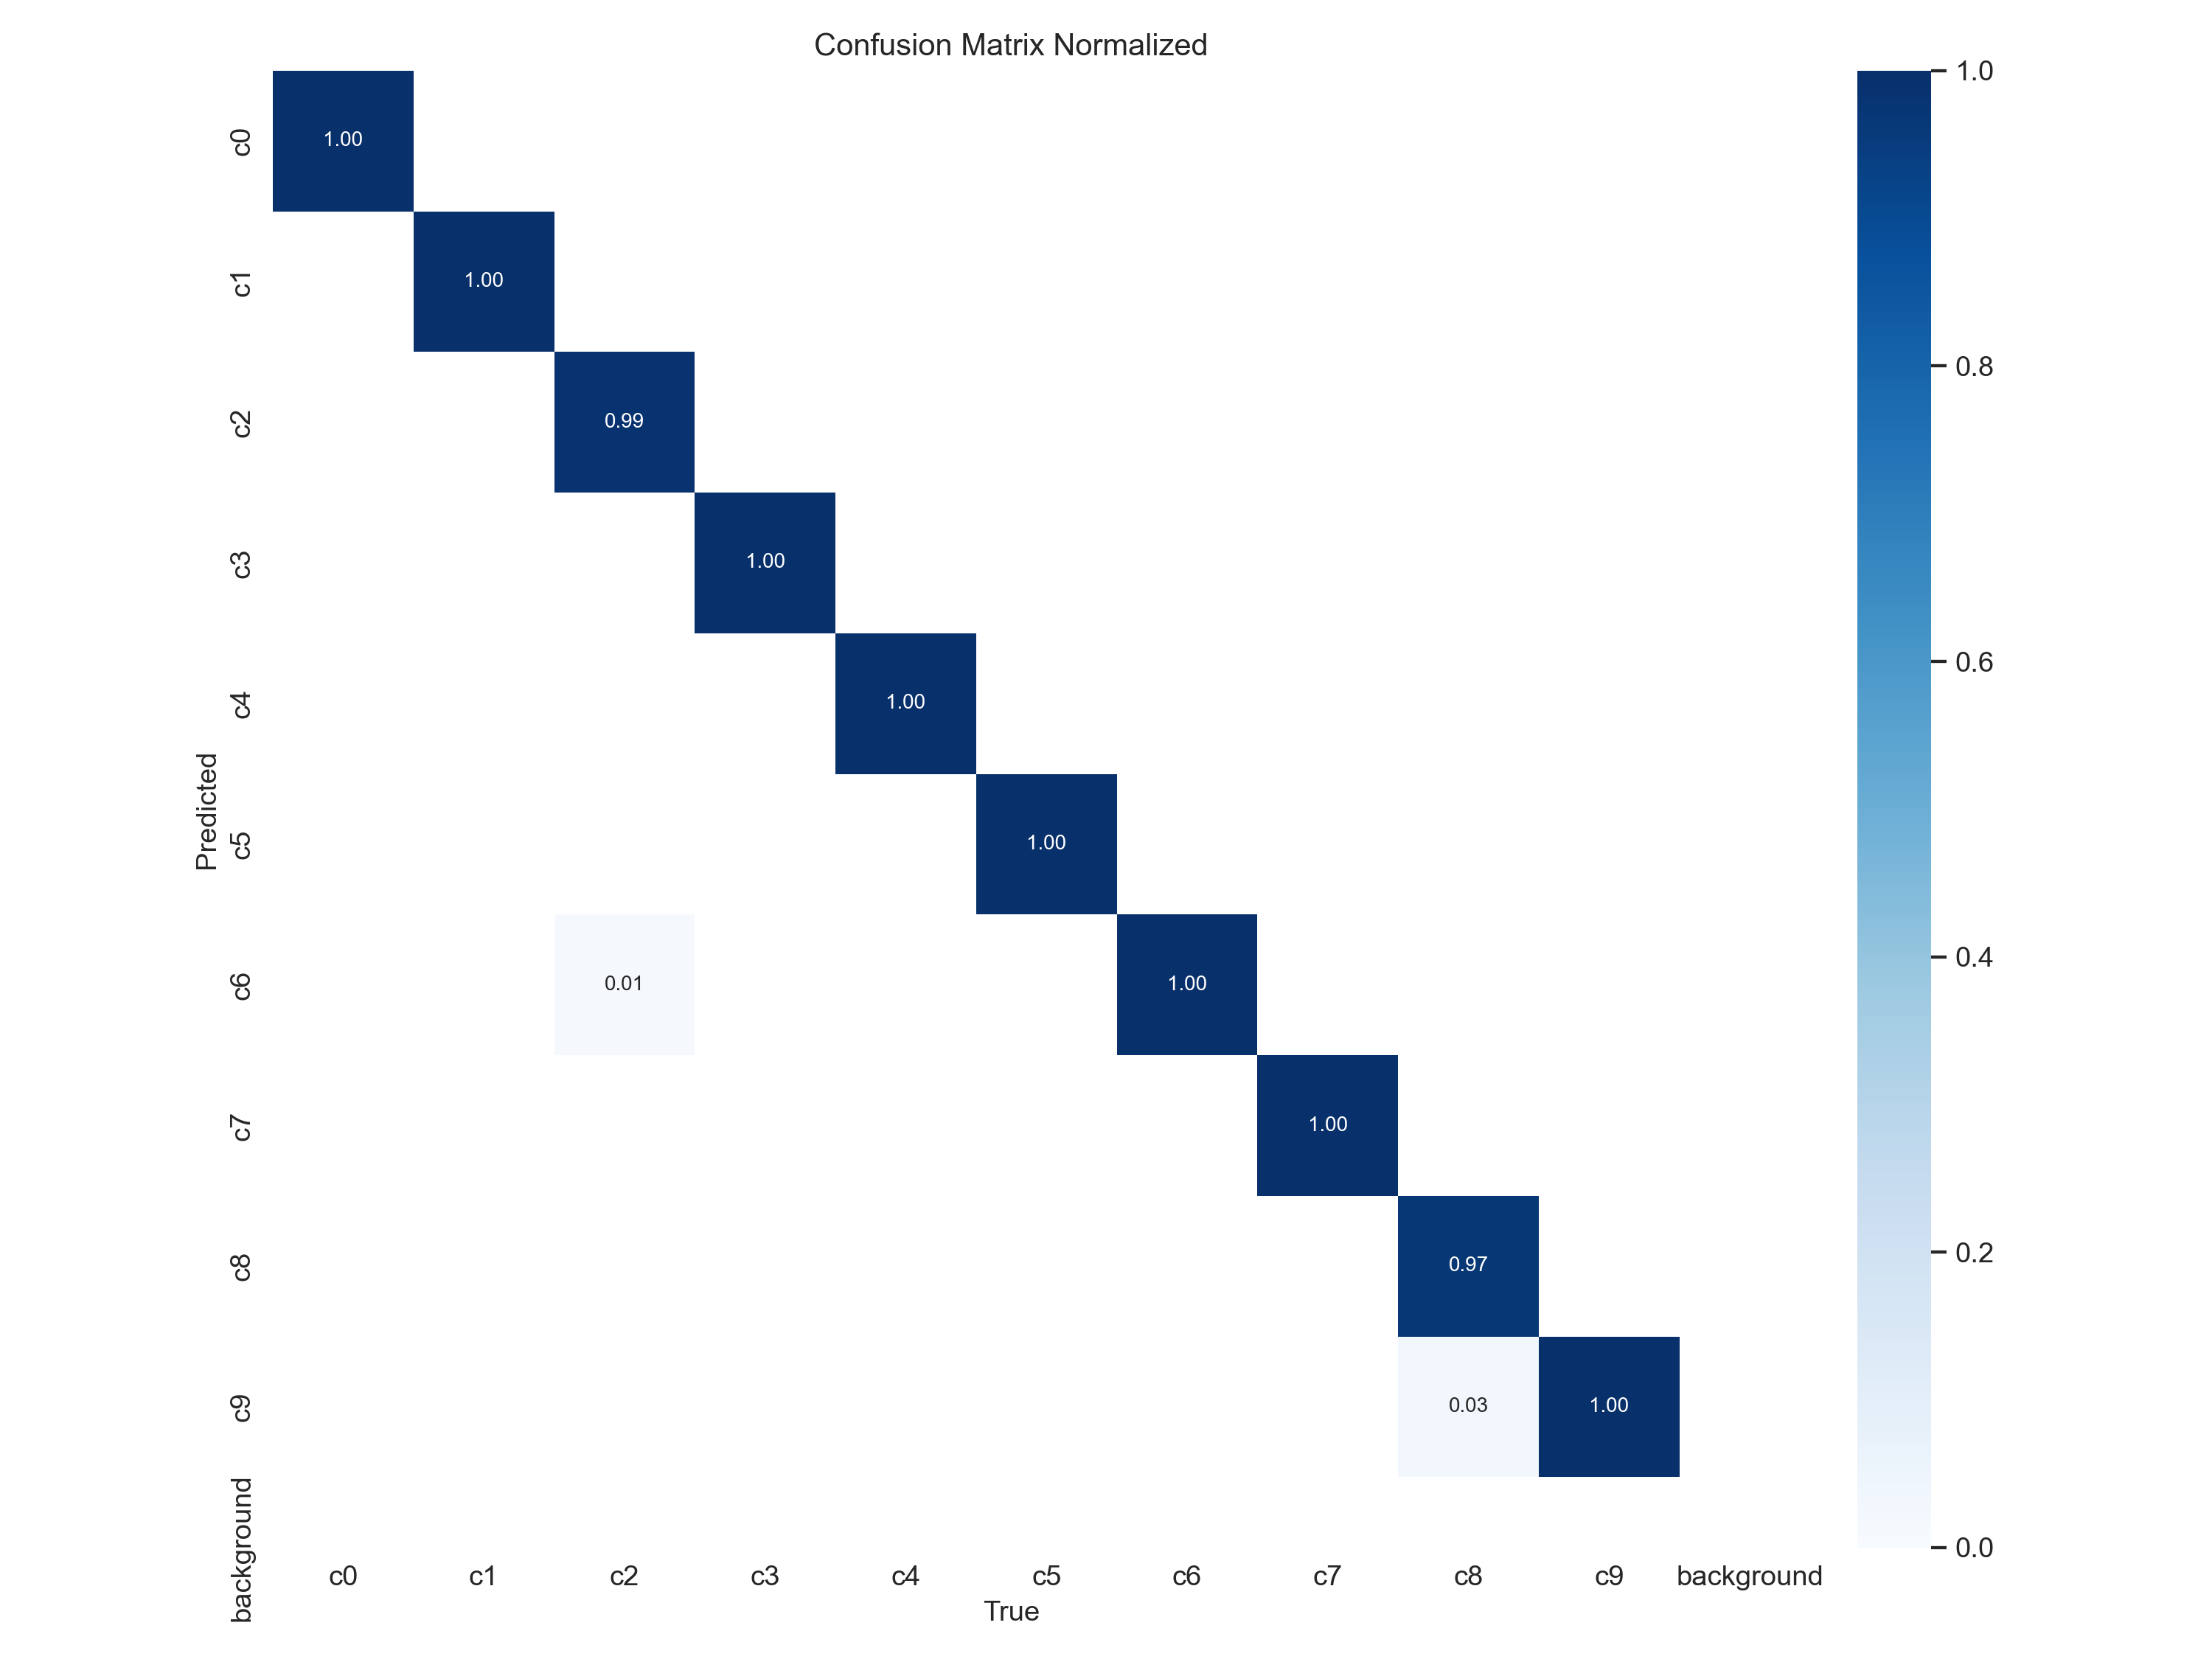

In [25]:
Image(r"D:\Personal\5. Courses\Depi\Technical\Runs\Classify\Train\confusion_matrix_normalized.png")

## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Prediction </div> 

In [27]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
test_images_path = test_dir
model_weights = r"D:\Personal\5. Courses\Depi\Technical\Runs\Classify\Train\weights\best.pt"

predicted_list = []

for clas in classes:
    image_dir = os.path.join(test_images_path, clas)
    # print(image_dir)
    images_list = os.listdir(image_dir)
    # print(images_list)
    # Class label in the form of 0 to 9
    class_label = int(clas[-1])
    # print(class_label)
    for image in images_list:
        path = os.path.join(image_dir, image)
        # print(path)
        y_actual = class_label
        y_predicted = model.predict(path, model = model_weights)[0].probs.top1
        predicted_list.append([path, y_actual, y_predicted])


image 1/1 D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c0\img_11061.jpg: 224x224 c0 1.00, c3 0.00, c1 0.00, c9 0.00, c4 0.00, 20.9ms
Speed: 7.0ms preprocess, 20.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c0\img_11687.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c8 0.00, c4 0.00, 14.0ms
Speed: 6.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c0\img_11860.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c8 0.00, c5 0.00, 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c0\img_11863.jpg: 224x224 c0 1.00, c9 0.00, c8 0.00, c3 0.00, c4 0.00, 13.0ms
Speed: 7.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 D:\Personal\5. Courses\Depi\Technical\Dat

In [28]:
print("length of the Predicted List : ", len(predicted_list))

length of the Predicted List :  700


In [38]:
df = pd.DataFrame(predicted_list, columns = ['Image_path', 'Y_actual', 'Y_predicted'])
df.head()

Image_path  Y_actual  Y_predicted
0  D:\Personal\5. Courses\Depi\Technical\Dataset\...         0            0
1  D:\Personal\5. Courses\Depi\Technical\Dataset\...         0            0
2  D:\Personal\5. Courses\Depi\Technical\Dataset\...         0            0
3  D:\Personal\5. Courses\Depi\Technical\Dataset\...         0            0
4  D:\Personal\5. Courses\Depi\Technical\Dataset\...         0            0

In [31]:
print("Accuracy based on our VOLO V8 Model :- {:.2f}%".format(accuracy_score(df['Y_actual'], df['Y_predicted'])*100))

Accuracy based on our VOLO V8 Model :- 99.00%


## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Plot Confussion Matrix </div> 

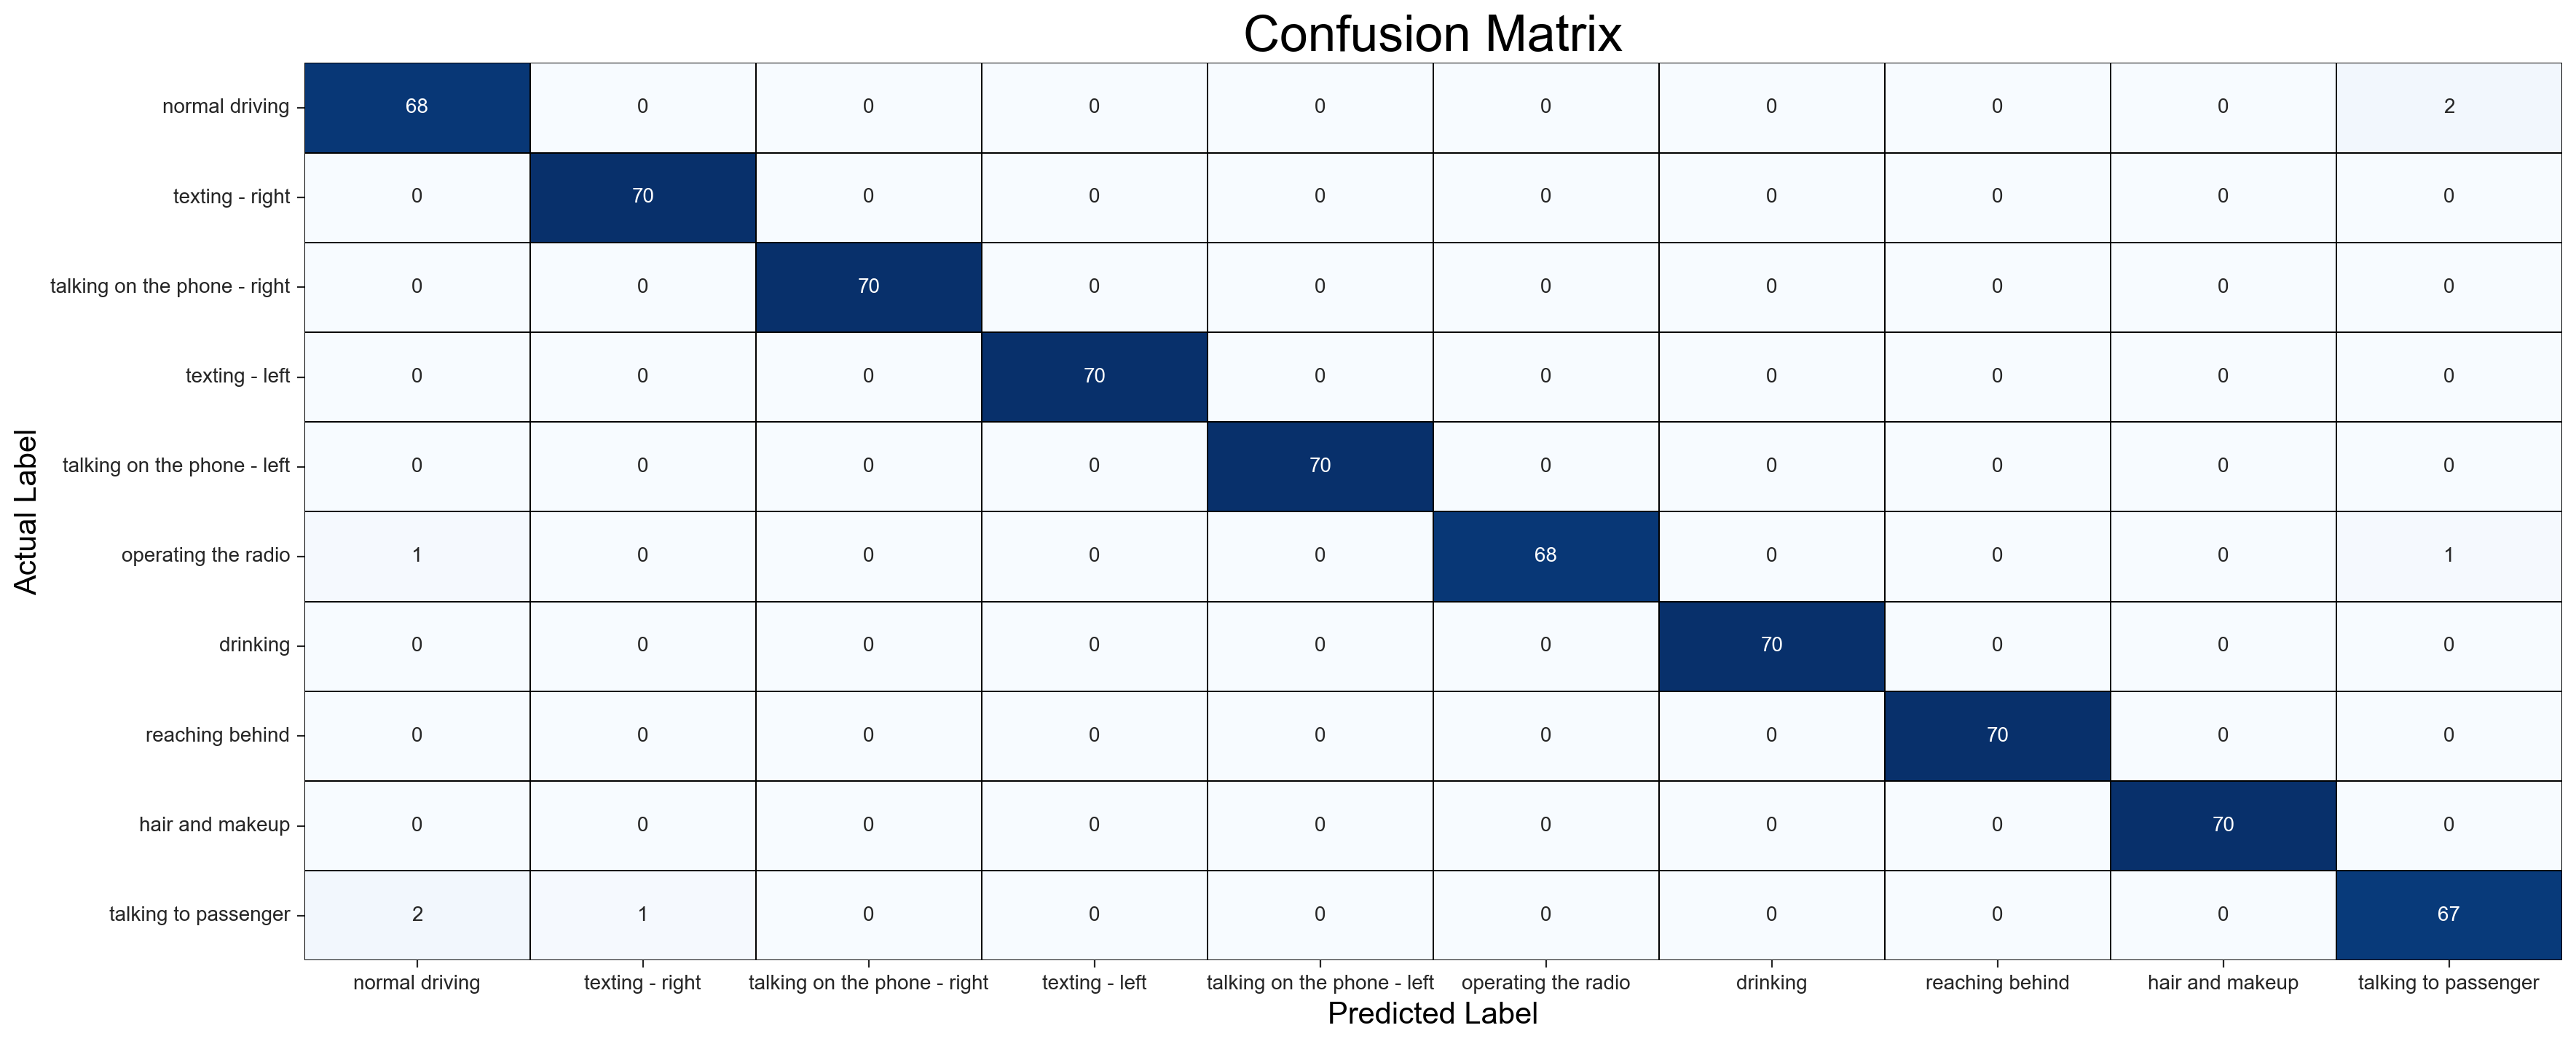

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define your categories based on the labels you have
categories = {
    0: 'normal driving',
    1: 'texting - right',
    2: 'talking on the phone - right',
    3: 'texting - left',
    4: 'talking on the phone - left',
    5: 'operating the radio',
    6: 'drinking',
    7: 'reaching behind',
    8: 'hair and makeup',
    9: 'talking to passenger'
}

# Generate the confusion matrix
confusion_mtx = confusion_matrix(df["Y_actual"], df["Y_predicted"]) 

# Plotting the confusion matrix
f, ax = plt.subplots(figsize=(20, 8), dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.1, cmap="Blues", 
            linecolor="black", fmt='d', ax=ax, 
            cbar=False, xticklabels=categories.values(), 
            yticklabels=categories.values())

plt.xlabel("Predicted Label", fontdict={'color': 'black', 'size': 15})
plt.ylabel("Actual Label", fontdict={'color': 'black', 'size': 15})
plt.title("Confusion Matrix", fontdict={'color': 'black', 'size': 25})

plt.show()



## <div style="background-color:#015958;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black"> Predict Images </div> 


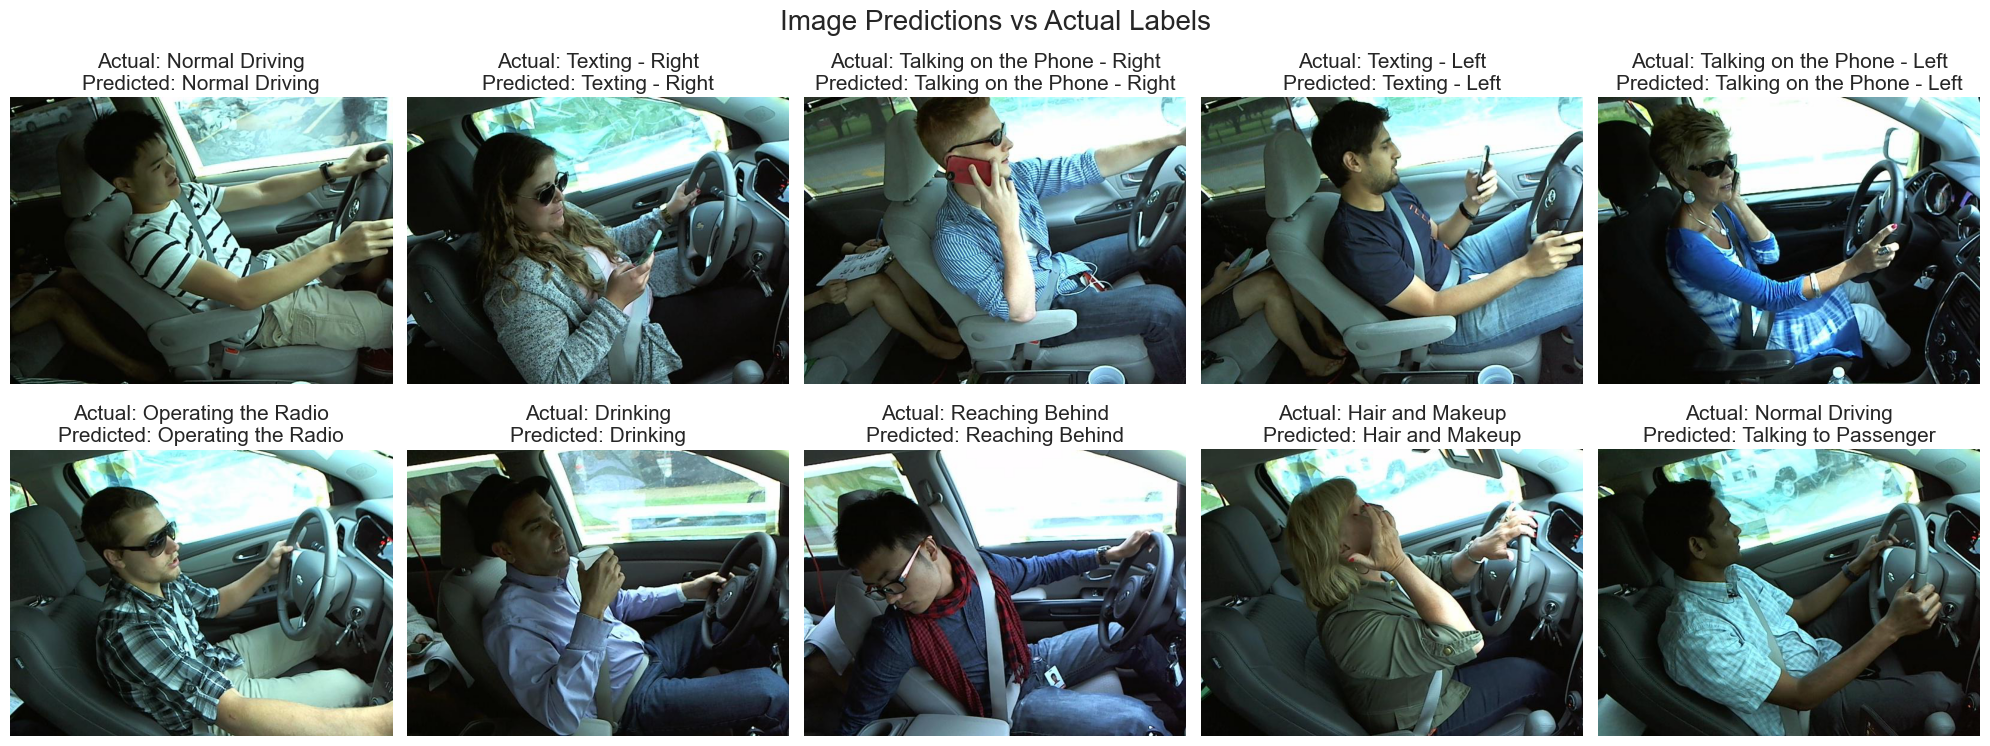

In [152]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

predicted_list = [
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c0\img_17794.jpg", "Normal Driving", "Normal Driving"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c1\img_25412.jpg", "Texting - Right", "Texting - Right"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c2\img_12723.jpg", "Talking on the Phone - Right", "Talking on the Phone - Right"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c3\img_27703.jpg", "Texting - Left", "Texting - Left"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c4\img_29229.jpg", "Talking on the Phone - Left", "Talking on the Phone - Left"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c5\img_17571.jpg", "Operating the Radio", "Operating the Radio"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c6\img_11811.jpg", "Drinking", "Drinking"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c7\img_30938.jpg", "Reaching Behind", "Reaching Behind"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c8\img_13090.jpg", "Hair and Makeup", "Hair and Makeup"],
    [r"D:\Personal\5. Courses\Depi\Technical\Dataset\Test\c9\img_13396.jpg", "Normal Driving", "Talking to Passenger"]
]

# Set up the number of images to display
num_images = len(predicted_list)
rows = (num_images // 5) + (num_images % 5 > 0)  # Calculate rows needed for a 5-column layout
cols = 5  # Number of columns

# Create a figure
fig, ax = plt.subplots(rows, cols, figsize=(20, rows * 4))  # Adjust height per row
ax = ax.flatten()  # Flatten the axes array for easy indexing

# Loop through predicted_list and plot each image
for i, (img_path, actual, predicted) in enumerate(predicted_list):
    img = mpimg.imread(img_path)  # Read the image from the path
    ax[i].imshow(img)  # Display the image
    ax[i].set_title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=15)  # Set title with actual and predicted labels
    ax[i].axis('off')  # Hide the axes

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    ax[j].axis('off')

plt.suptitle("Image Predictions vs Actual Labels", fontsize=20)
plt.tight_layout()
plt.show()
